In [30]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
import os
font = cv2.FONT_HERSHEY_COMPLEX

#### Computer Vision Final Project
For my final project I chose to create a way of reading a table of data from a white board.

#### Outline
* Pre Processing
    - Find the table by finding the largest rectangle
    - Find the table/grid by finding the largest contours with minimal holes
    - Draw the contours and find straight lines
    - Decluster the lines found
    - Rewrite over the table/grid contours in order to hide them from the text processing
    - Divide into cells

* Text Processing
I had a bit of trouble getting the handwriting working. I tried 3 methods.
    - Pytesseract - https://pypi.org/project/pytesseract/
    - Pre-Trained TensorFlow Model - https://github.com/githubharald/SimpleHTR
    - Microsoft OCR API - https://westus.dev.cognitive.microsoft.com/docs/services/5adf991815e1060e6355ad44/operations/587f2c6a154055056008f200

In [2]:

def pre_process_image(img, skip_dilate=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)

    if(not skip_dilate):
        # Dilate the image to increase the size of the grid lines.
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
        proc = cv2.dilate(proc, kernel)

    return proc

In [3]:

def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""
    img = img.copy()
    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side) + 100, int(side) + 100))

In [4]:
import operator

def find_corners(polygon):
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]
    
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    return find_corners(polygon)


    

In [5]:
def find_rectangles(img):
    contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Draw all of the contours on the image in 2px red lines
    # all_contours = cv2.drawContours(processed, contours, -1, (255, 0, 0), 2)
    #     ext_contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    #     external_only = 
    rectangles = []
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.01 * peri, True)
        if(len(approx)) == 4:
            rectangles.append(approx)
    return rectangles

def draw_corners(img, corners):
    [cv2.circle(img, tuple(circle), 1, (255, 255, 0), 100) for circle in corners]

In [6]:
def process_and_crop(img, con):
    process = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    processed = pre_process_image(process, True)
    corners = find_corners_of_largest_polygon(processed)
    # convert image to gray scale image 
    return crop_and_warp(con, corners)

def draw_contours(img):
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # cv2.imshow("blur1", blur)

    thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
    # cv2.imshow("thresh1", thresh)

    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    bgr = np.zeros((img.shape[0], img.shape[1]), dtype= 'uint8')
    c = 0
    drawn = []
    for i in contours:
        area = cv2.contourArea(i)
        if area > 2000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.01 * peri, True)
            if(peri > 1000):
                drawn.append(i)
                cv2.drawContours(bgr, contours, c, (255, 0, 0), 5)
        c+=1
    return [bgr, drawn]

In [7]:
def get_lines_p(img):
    edges = cv2.Canny(img,10,50,apertureSize = 7, L2gradient = True)
    cv2.imwrite('edges-50-150.jpg',edges)
    minLineLength=1000

    return cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/2, threshold=100, lines=np.array([]), minLineLength=minLineLength, maxLineGap=500)

def get_lines(img):
    edges = cv2.Canny(img, 100, 200, apertureSize = 3, L2gradient = True)

    lines = cv2.HoughLines(edges,1,np.pi/180,50)
    lines = [line[0] for line in lines]
    return lines

def clean_lines_using_text(img, lines):
    horz, vert = get_lines(img)
    

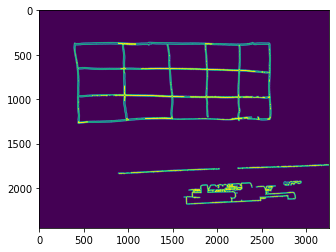

For Finding Lines


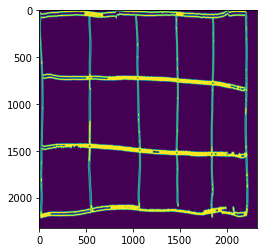

For Finding Text


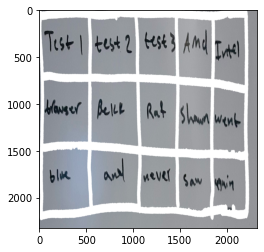

In [8]:
img = cv2.imread("/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg")

# Get the contours
con, contours = draw_contours(img.copy())
# Draw contours for later
cv2.drawContours(img, contours, -1, (255, 255, 255), 22)
plt.imshow(con)
plt.show()




# Pre Process and Crop the Image to find Lines
cropped = process_and_crop(img, con)
print("For Finding Lines")
plt.imshow(cropped)
plt.show()
lines = get_lines(cropped)
line_length = cropped.shape[0]
vertices = []
for rho,theta in lines:
    if(theta < .001 or abs(theta - np.pi/2) < .001):
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        vertices.append((x0, y0))


# Get image for text recognition
new_img = process_and_crop(img, img)
print("For Finding Text")
plt.imshow(new_img)

Now really for finding text


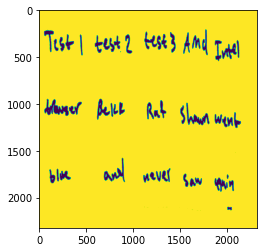

In [9]:
(thresh, blackAndWhiteImage) = cv2.threshold(cv2.cvtColor(new_img.copy(), cv2.COLOR_BGR2GRAY), 127, 255, cv2.THRESH_BINARY)
new_img = blackAndWhiteImage
print("Now really for finding text")
plt.imshow(new_img)

In [10]:
_y = sorted([vertice[1] for vertice in vertices if vertice[0] < 5])
_x = sorted([vertice[0] for vertice in vertices if vertice[1] < 5])

In [11]:
y_lines = [_y[0]]
x_lines = [_x[0]]
# Improvement: We could probably make ranges and take the average here
for num in _y:
    if(abs(num - y_lines[-1]) > 200):
        y_lines.append(num)
for num in _x:
    if(abs(num - x_lines[-1]) > 200):
        x_lines.append(num)

In [12]:
print(x_lines, "\n\n", y_lines)

[1.0, 522.0, 1035.0, 1454.0, 1828.0, 2191.0] 

 [0.0, 677.0, 1422.0, 2075.0]


In [13]:
table = []
row = 0
for y_window in range(len(y_lines) - 1):
    table.append([])
    for x_window in range(len(x_lines) - 1):
        # Rectangle described by top left, top right, bottom right and bottom left points
        corners = [(x_lines[x_window], y_lines[y_window]), (x_lines[x_window + 1], y_lines[y_window]), (x_lines[x_window + 1], y_lines[y_window + 1]), (x_lines[x_window], y_lines[y_window + 1])]
        table[row].append(crop_and_warp(new_img, corners))
    row = row + 1
# plt.imshow(new_img)
# plt.show()

(777, 777)


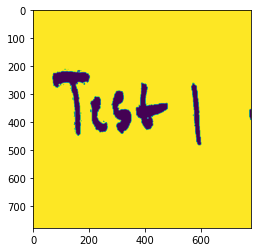

Teok |
(777, 777)


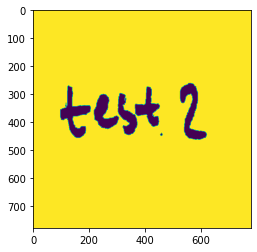

ry]
(777, 777)


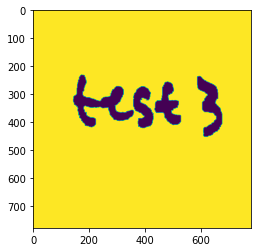

test
(777, 777)


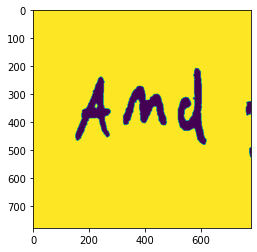

Amd
(777, 777)


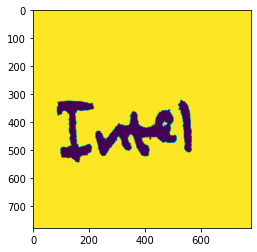

Twit)
(845, 845)


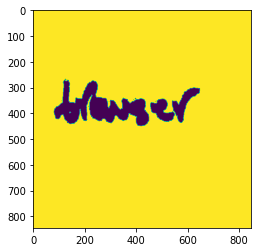

dloang er
(845, 845)


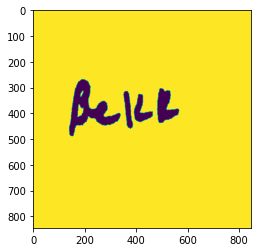

Beltl
(845, 845)


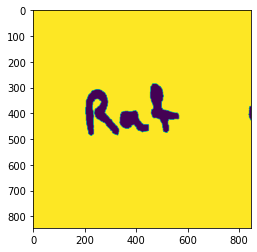

Rak
(845, 845)


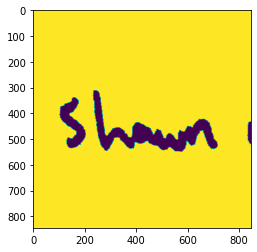

Shown
(845, 845)


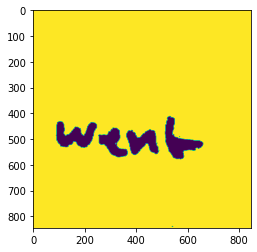

Wen
(753, 753)


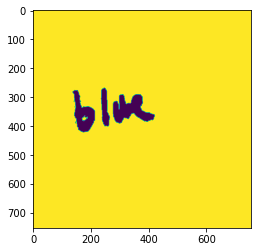

ble
(753, 753)


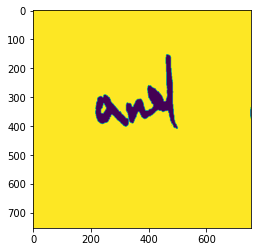

a
(753, 753)


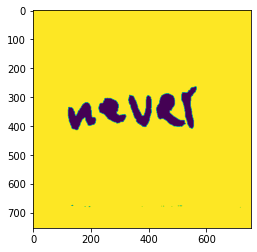

weve
(753, 753)


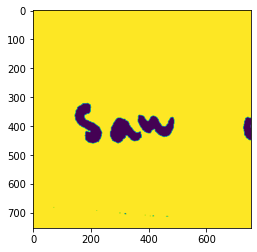

Saw

{
(753, 753)


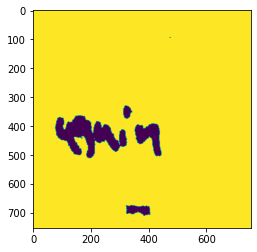

En


In [14]:
import pytesseract
for row in table:
    for cell in row:
        print(cell.shape)
        plt.imshow(cell)
        plt.show()
        print(pytesseract.image_to_string(cell, config = r'--psm 11 --oem 1'))
# plt.imshow(new_img)
# plt.show()
# print(pytesseract.image_to_string(new_img))

In [15]:
from SimpleHTR.src.main import predict

In [16]:
data = np.array(np.array(table).shape)

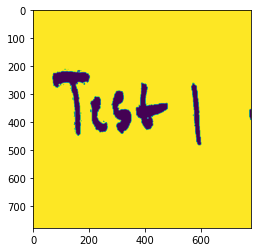

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "Furs"
Probability: 0.014798752


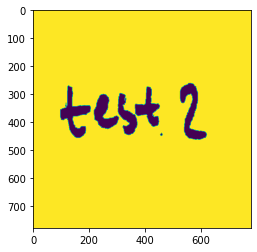

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "ue"
Probability: 0.03014552


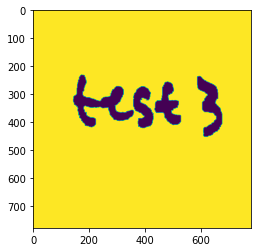

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "us"
Probability: 0.01747138


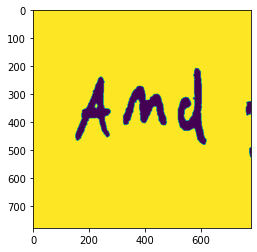

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "sn"
Probability: 0.0035724018


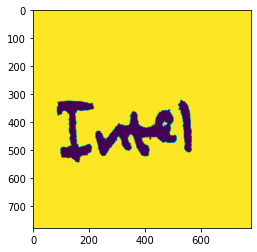

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "sor"
Probability: 0.0119571425


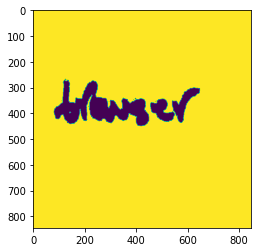

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "wer"
Probability: 0.0012430047


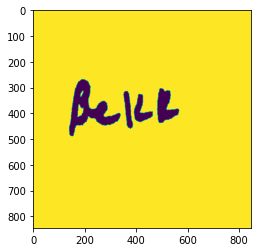

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "wue"
Probability: 0.00808249


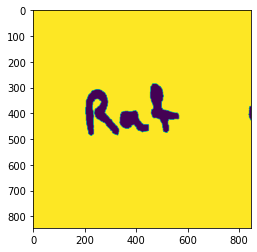

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "ro"
Probability: 0.009869174


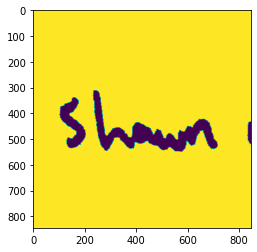

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "stmo"
Probability: 0.015836827


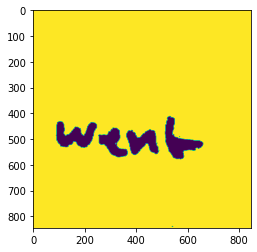

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "ouw"
Probability: 0.003169142


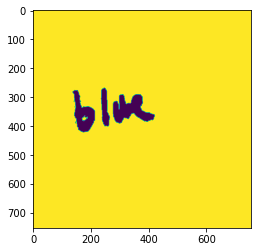

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "won"
Probability: 0.094506174


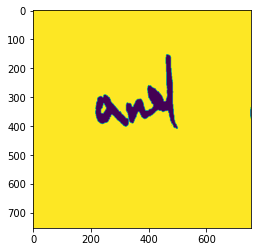

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "lve"
Probability: 0.012078452


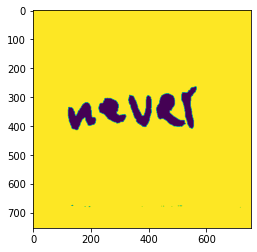

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "muer"
Probability: 0.018862726


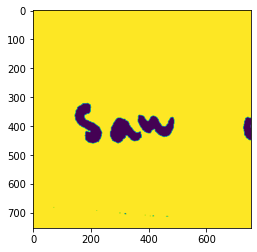

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "wor"
Probability: 0.01496291


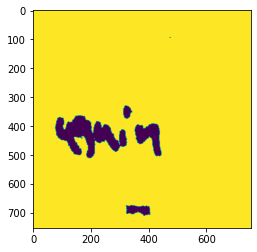

Validation character error rate of saved model: 10.624916%
Python: 3.7.7 (default, Mar 10 2020, 15:43:03) 
[Clang 11.0.0 (clang-1100.0.33.17)]
Tensorflow: 1.15.0
Init with stored values from SimpleHTR/model/snapshot-38
Recognized: "soin"
Probability: 0.032437656


In [18]:
import tensorflow as tf
for row in table:
    for cell in row:
        plt.imshow(cell)
        plt.show()
        tf.reset_default_graph()
        predict(cell)

In [19]:
data = np.empty_like(np.array(table))
print(data)

[[None None None None None]
 [None None None None None]
 [None None None None None]]


In [20]:
import requests

import asyncio


async def promise(check, response):
    # Get the current event loop.
    loop = asyncio.get_running_loop()

    # Create a new Future object.
    fut = loop.create_future()

    # Run "set_after()" coroutine in a parallel Task.
    # We are using the low-level "loop.create_task()" API here because
    # we already have a reference to the event loop at hand.
    # Otherwise we could have just used "asyncio.create_task()".
    loop.create_task(check(fut, response))

    return(await fut)



In [31]:
def get_text(img):
    url = "https://textextracttable.cognitiveservices.azure.com/vision/v2.0/recognizeText?mode=Handwritten"

    payload = cv2.imencode('.jpg', img)[1].tostring()
    headers = {
        'Ocp-Apim-Subscription-Key': "3e29598d653646b0a95b36fb6c785a09",
        'content-type': "application/octet-stream"
        }

    response = requests.request("POST", url, data=payload, headers=headers)

    return response

def get_status(response):
    return requests.request('GET', response.headers['Operation-Location'], headers = {'Ocp-Apim-Subscription-Key': os.environ['ocpKey']}).json()



In [32]:

def parse(res):
    print(res)
    if(res["status"] == "Succeeded"):
        return [lines["text"] for lines in res["recognitionResult"]["lines"] if lines["text"]]
    return "Failed"

async def check(fut, response):
    i = 0
    for i in range(5):
        print("Next Iteration: ", i)
        res = get_status(response)
        parsed = parse(res)
        if(parsed != "Failed"):
            fut.set_result(parsed)
            break
        else:
            await asyncio.sleep(2)
            

errors = []
promises = []
for i, row in enumerate(table):
    for j, cell in enumerate(row):
        res = get_text(cell)
        data[i][j] = await promise(check, res)
        

Next Iteration:  0
{'status': 'Running'}
Next Iteration:  1
{'status': 'Succeeded', 'recognitionResult': {'lines': [{'boundingBox': [65, 218, 614, 247, 610, 469, 79, 458], 'text': 'Test 1', 'words': [{'boundingBox': [112, 219, 510, 234, 502, 473, 103, 458], 'text': 'Test', 'confidence': 'Low'}, {'boundingBox': [558, 235, 606, 237, 597, 476, 549, 474], 'text': '1', 'confidence': 'Low'}]}]}}
Next Iteration:  0
{'status': 'Running'}
Next Iteration:  1
{'status': 'Succeeded', 'recognitionResult': {'lines': [{'boundingBox': [83, 276, 595, 265, 599, 453, 100, 458], 'text': 'test 2', 'words': [{'boundingBox': [107, 272, 495, 266, 498, 454, 110, 460], 'text': 'test'}, {'boundingBox': [533, 265, 595, 264, 598, 452, 536, 453], 'text': '2'}]}]}}
Next Iteration:  0
{'status': 'Running'}
Next Iteration:  1
{'status': 'Succeeded', 'recognitionResult': {'lines': [{'boundingBox': [145, 257, 666, 233, 662, 446, 174, 444], 'text': 'test 3', 'words': [{'boundingBox': [157, 242, 541, 234, 545, 447, 162, 4

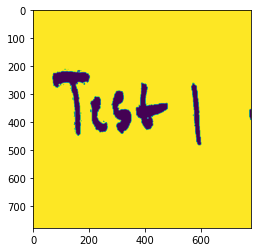

['Test 1'] 




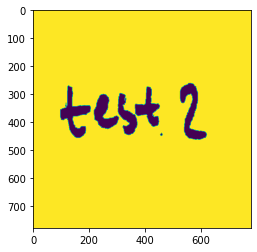

['test 2'] 




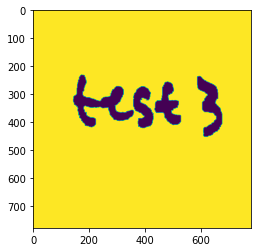

['test 3'] 




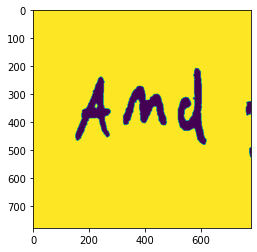

['no'] 




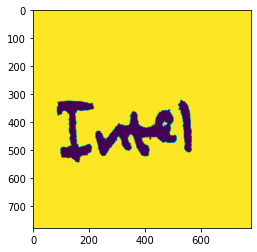

['In'] 




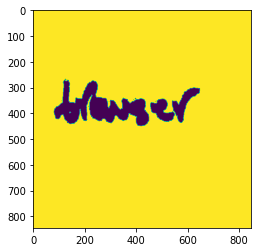

['ser'] 




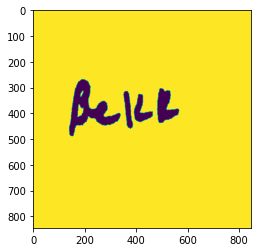

['BeILL'] 




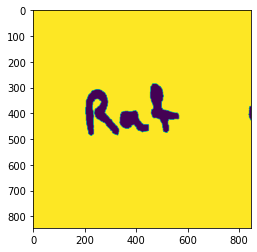

['Raf'] 




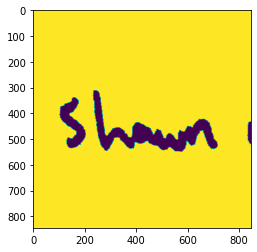

['Sha'] 




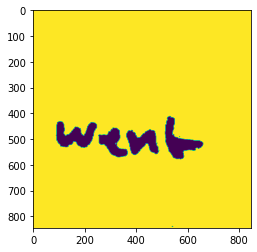

['ent'] 




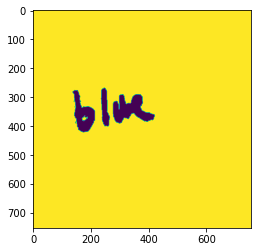

['blue'] 




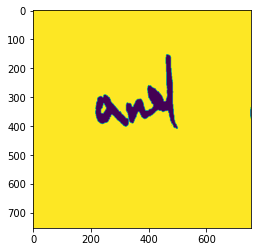

['any'] 




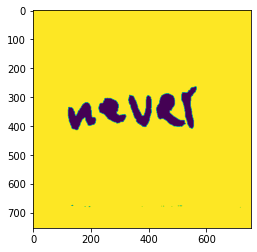

['never'] 




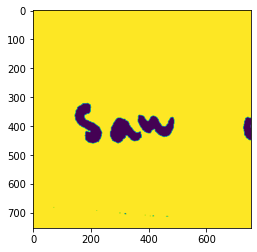

['Saw'] 




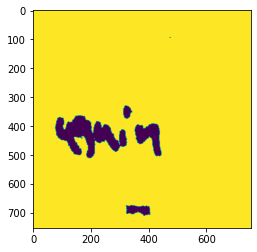

[] 




In [33]:
# Lets check it out
for i, row in enumerate(table):
    for j, cell in enumerate(row):
        plt.imshow(cell)
        plt.show()
        print(data[i][j], "\n\n")

In [34]:
# Lets see how it would do without preprocessing
await promise(check, get_text(img))

Next Iteration:  0
{'status': 'Running'}
Next Iteration:  1
{'status': 'Succeeded', 'recognitionResult': {'lines': [{'boundingBox': [451, 437, 898, 442, 896, 565, 449, 559], 'text': 'Test 1', 'words': [{'boundingBox': [490, 444, 775, 444, 778, 562, 491, 562], 'text': 'Test'}, {'boundingBox': [845, 447, 891, 449, 894, 565, 848, 564], 'text': '1', 'confidence': 'Low'}]}, {'boundingBox': [1001, 458, 1411, 457, 1412, 557, 1002, 558], 'text': 'test 2', 'words': [{'boundingBox': [1021, 458, 1301, 460, 1302, 558, 1022, 558], 'text': 'test'}, {'boundingBox': [1347, 459, 1412, 459, 1412, 554, 1347, 556], 'text': '2'}]}, {'boundingBox': [1521, 444, 2230, 453, 2228, 558, 1519, 550], 'text': 'test 3 Amd', 'words': [{'boundingBox': [1544, 453, 1790, 452, 1788, 552, 1543, 541], 'text': 'test'}, {'boundingBox': [1824, 452, 1881, 452, 1879, 555, 1822, 553], 'text': '3'}, {'boundingBox': [1966, 452, 2229, 453, 2226, 558, 1964, 556], 'text': 'Amd'}]}, {'boundingBox': [2239, 482, 2525, 477, 2532, 580, 22

['Test 1',
 'test 2',
 'test 3 Amd',
 'Intel',
 'browser',
 'BelLK',
 'Rat',
 'Shawn went',
 'any',
 'never',
 'Saw',
 'AP']

In [35]:
# Lets see how it does with just a little
await promise(check, get_text(new_img))

Next Iteration:  0
{'status': 'Running'}
Next Iteration:  1
{'status': 'Succeeded', 'recognitionResult': {'lines': [{'boundingBox': [51, 218, 1859, 249, 1855, 483, 47, 452], 'text': 'Test | test ? fest? And', 'words': [{'boundingBox': [82, 222, 375, 225, 373, 460, 82, 458], 'text': 'Test'}, {'boundingBox': [421, 226, 560, 228, 556, 462, 418, 461], 'text': '|', 'confidence': 'Low'}, {'boundingBox': [606, 228, 883, 234, 877, 466, 602, 463], 'text': 'test'}, {'boundingBox': [929, 235, 1083, 238, 1075, 468, 923, 466], 'text': '?', 'confidence': 'Low'}, {'boundingBox': [1129, 240, 1499, 251, 1488, 472, 1121, 468], 'text': 'fest?', 'confidence': 'Low'}, {'boundingBox': [1545, 253, 1853, 265, 1839, 475, 1534, 472], 'text': 'And', 'confidence': 'Low'}]}, {'boundingBox': [68, 889, 2159, 1043, 2142, 1280, 50, 1126], 'text': 'Hauser Belk Rat Shown went', 'words': [{'boundingBox': [64, 947, 510, 941, 504, 1148, 59, 1131], 'text': 'Hauser', 'confidence': 'Low'}, {'boundingBox': [631, 942, 980, 957,

['Test | test ? fest? And',
 'Hauser Belk Rat Shown went',
 'blue',
 'any',
 'never saw main']